In [1]:
%matplotlib inline
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
from sklearn.metrics import r2_score
from torch import nn, optim
from torch.autograd import Variable
from torch_lr_finder import LRFinder

np.random.seed(14)  # For reproducibility
torch.manual_seed(14)  # For reproducibility

In [2]:
from L96_model import (
    L96,
    RK2,
    RK4,
    EulerFwd,
    L96_eq1_xdot,
    integrate_L96_2t,
)

In [3]:
time_steps = 20000
Forcing, dt, T = 18, 0.01, 0.01 * time_steps

# Create a "synthetic world" with K=8 and J=32
K = 8
J = 32
W = L96(K, J, F=Forcing)
# Get training data for the neural network.

# - Run the true state and output subgrid tendencies (the effect of Y on X is xytrue):
Xtrue, _, _ = W.run(dt, T, store=True)

In [4]:
# Specify a path
PATH = "networks/network_3_layers_100_epoches.pth"
# Load
model = torch.load(PATH)
model.keys()

odict_keys(['linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias', 'linear3.weight', 'linear3.bias'])

In [5]:
for name in model.keys():
    print(name)

linear1.weight
linear1.bias
linear2.weight
linear2.bias
linear3.weight
linear3.bias


In [6]:
epsilon = 0.0  # filtering small values
gamma = 0.0  # give more weights to positive values

## get the weight and bias of the NN
def get_weight(modelname):
    Ws = []
    Bs = []
    for (i, name) in enumerate(model.keys()):
        if i % 2 == 0:
            Ws.append(np.array(model[name]))
        else:
            Bs.append(np.array(model[name]))
    return Ws, Bs  # weights and biases


# forward pass to calculate the output of each layer
def forward_pass(data, Ws, Bs):
    L = len(Ws)
    forward = [data] + [None] * L

    for l in range(L - 1):
        forward[l + 1] = np.maximum(0, Ws[l].dot(forward[l])) + Bs[l]  # ativation ReLu

    ## for last layer that does not have activation function

    forward[L] = Ws[L - 1].dot(forward[L - 1]) + Bs[L - 1]  # linear last layer
    return forward


def rho(w, l):
    w_intermediate = w + [0.0, 0.0, 0.0, 0.0, 0.0][l] * np.maximum(0, w)
    return w_intermediate + gamma * np.maximum(0, w_intermediate)


def incr(z, l):
    return z + [0.0, 0.0, 0.0, 0.0, 0.0][l] * (z**2).mean() ** 0.5 + 1e-9


## backward pass to compute the LRP of each layer. Same rule applied to the first layer (input layer)
def onelayer_LRP(W, B, forward, nz, zz):
    mask = np.zeros((nz))
    mask[zz] = 1
    L = len(W)
    R = [None] * L + [forward[L] * mask]  # start from last layer Relevance

    for l in range(0, L)[::-1]:
        w = rho(W[l], l)
        b = rho(B[l], l)
        z = incr(w.dot(forward[l]) + b + epsilon, l)  # step 1 - forward pass
        s = np.array(R[l + 1]) / np.array(z)  # step 2 - element-wise division
        c = w.T.dot(s)  # step 3 - backward pass
        R[l] = forward[l] * c  # step 4 - element-wise product

    return R


def LRP_alllayer(data, model):
    """inputs:
        data: for single sample, with the right asix, the shape is (nz,naxis)
        model: dictionary of weights and biases
    output:
        LRP, shape: (nx,L+1) that each of the column consist of L+1 array
        Relevance of fisrt layer's pixels"""
    nx = data.shape[0]
    ## step 1: get the wieghts
    Ws, Bs = get_weight(model)

    ## step 2: call the forward pass to get the intermediate layers output
    inter_layer = forward_pass(data, Ws, Bs)

    ## loop over all z and get the LRP of each layer
    R_all = [None] * nx
    relevance = np.zeros((nx, nx))
    for xx in range(nx):
        R_all[xx] = onelayer_LRP(Ws, Bs, inter_layer, nx, xx)
        relevance[xx, :] = R_all[xx][0]

    return np.stack(R_all), relevance

In [7]:
R_many = []
for case in range(200):
    inputs = np.copy(Xtrue[case, :])

    _, Rs = LRP_alllayer(inputs, model)
    R_many.append(Rs)

/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [8]:
Rstack = np.stack(R_many)

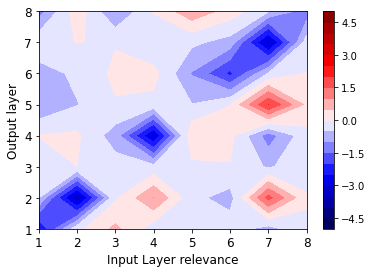

In [9]:
fig, ax = plt.subplots(1, 1)
vect = np.arange(-5, 5.1, 0.5)
pl = ax.contourf(
    np.arange(1, 9),
    np.arange(1, 9),
    np.mean(Rstack, 0),
    vect,
    cmap=plt.get_cmap("seismic"),
)
ax.set_ylabel("Output layer", fontsize=12)
ax.set_xlabel("Input Layer relevance", fontsize=12)
ax.tick_params(axis="both", labelsize=12)

fig.colorbar(pl)
fig.savefig("LRP-L96.jpeg", bbox_inches="tight", dpi=150)

In [10]:
# now take gradient - nabla_x(y) - note data was not normalized in this example!

In [11]:
# define network structure in pytorch
import torch.nn.functional as FF


class Net_ANN(nn.Module):
    def __init__(self):
        super(Net_ANN, self).__init__()
        self.linear1 = nn.Linear(8, 16)  # 8 inputs, 16 neurons for first hidden layer
        self.linear2 = nn.Linear(16, 16)  # 16 neurons for second hidden layer
        self.linear3 = nn.Linear(16, 8)  # 8 outputs

    #         self.lin_drop = nn.Dropout(0.1) #regularization method to prevent overfitting.

    def forward(self, x):
        x = FF.relu(self.linear1(x))
        x = FF.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [12]:
model = Net_ANN()
model.load_state_dict(torch.load(PATH))
model.eval()

Net_ANN(
  (linear1): Linear(in_features=8, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=16, bias=True)
  (linear3): Linear(in_features=16, out_features=8, bias=True)
)

In [13]:
epsilon = 1e-2
R_many = []
std_vec = np.std(Xtrue, axis=0)
print(std_vec)
for case in range(200):
    inputs = np.copy(Xtrue[case, :])
    # estimate dy/dx = (y(x+epsilon)-y(x))/epsilon
    # TODO need to perturb every components
    inputs = torch.tensor(np.single(inputs), requires_grad=False)
    pred = model(inputs)
    perturb = np.single(np.zeros(np.shape(inputs)))
    Rs = np.zeros((len(inputs), len(pred)))
    for j in range(len(inputs)):
        perturb[j] = epsilon
        perturb = perturb  # *std_vec # percent change
        Rs[j, :] = (
            model(torch.tensor(inputs + perturb)) - model(inputs)
        ).detach().numpy() / (np.sum(perturb))
    R_many.append(Rs)

[4.55719436 4.49180031 4.48200123 4.57005852 4.67042184 4.55764743
 4.65432827 4.49010761]


<ipython-input-13-67bd276c32e6>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Rs[j,:] = ( model(torch.tensor(inputs+perturb))-model(inputs) ).detach().numpy() /(np.sum(perturb))


In [14]:
Rstack = np.stack(R_many)

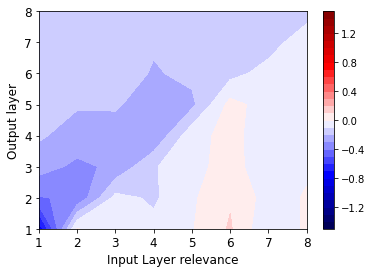

In [15]:
fig, ax = plt.subplots(1, 1)
vect = np.arange(-1.5, 1.6, 0.1)
pl = ax.contourf(
    np.arange(1, 9),
    np.arange(1, 9),
    np.mean(Rstack, 0),
    vect,
    cmap=plt.get_cmap("seismic"),
)
ax.set_ylabel("Output layer", fontsize=12)
ax.set_xlabel("Input Layer relevance", fontsize=12)
ax.tick_params(axis="both", labelsize=12)

fig.colorbar(pl)
fig.savefig("LRP-L96-gradient.jpeg", bbox_inches="tight", dpi=100)